In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast, GaussNoise, CLAHE, HueSaturationValue
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import seaborn as sns
from sklearn.model_selection import cross_val_score

os.chdir(r"D:\RP_FireDetection\FinalWork")  # Set working directory

In [14]:
def load_images_with_labels(fire_dirs, non_fire_dirs, image_size=(224, 224)):

    data = []
    labels = []

    for label, dirs in enumerate([(non_fire_dirs, 0), (fire_dirs, 1)]):  # 0: non-fire, 1: fire
        for folder in dirs[0]:
            for filename in tqdm(os.listdir(folder), desc=f"Loading {os.path.basename(folder)}"):
                try:
                    file_path = os.path.join(folder, filename)
                    img = cv2.imread(file_path)
                    if img is not None:
                        # Resize image to a fixed size
                        img = cv2.resize(img, image_size)
                        data.append(img)
                        labels.append(dirs[1])
                    else:
                        print(f"Warning: Image not loaded {file_path}")
                except Exception as e:
                    print(f"Error loading image: {file_path} - {e}")
    
    # Convert to numpy arrays
    return np.array(data), np.array(labels)

In [15]:
# Define your directories
fire_dirs = [
    r"D:\RP_FireDetection\FinalWork\fire_dataset\fire_images",
    r"D:\RP_FireDetection\FinalWork\FireDatasetPCD\Train\Fire"
]
non_fire_dirs = [
    r"D:\RP_FireDetection\FinalWork\fire_dataset\non_fire_images",
    r"D:\RP_FireDetection\FinalWork\FireDatasetPCD\Train\Neutral"
]

# Load the combined dataset with resized images
X_images, y_labels = load_images_with_labels(fire_dirs, non_fire_dirs)
print(f"Dataset loaded. Shapes: X_images: {X_images.shape}, y_labels: {y_labels.shape}")


Loading non_fire_images:  38%|███▊      | 93/244 [00:00<00:01, 94.66it/s] 

Loading Neutral:  58%|█████▊    | 772/1333 [00:01<00:00, 706.76it/s]

Loading Fire: 100%|██████████| 987/987 [00:00<00:00, 1767.01it/s]


Dataset loaded. Shapes: X_images: (3317, 224, 224, 3), y_labels: (3317,)


In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)

augmentation_pipeline = Compose([
    Resize(224, 224),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    CLAHE(p=0.3),
    GaussNoise(p=0.2),
    HueSaturationValue(p=0.3)
])

def augment_data(images):
    augmented_data = []
    for img in tqdm(images, desc="Augmenting data"):
        augmented = augmentation_pipeline(image=img)
        augmented_data.append(augmented['image'])
    return np.array(augmented_data)

X_train_augmented = augment_data(X_train)

Augmenting data: 100%|██████████| 2321/2321 [00:01<00:00, 2145.67it/s]


In [17]:
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_hsv_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_lbp_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_cnn_features(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(image_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = cnn_model.predict(img_array, verbose=0)
    return features.flatten()

def extract_all_features_batch(images):
    all_features = []
    for img in tqdm(images, desc="Extracting features"):
        color_feat = extract_hsv_histogram(img)
        texture_feat = extract_lbp_texture(img)
        cnn_feat = extract_cnn_features(img)
        combined = np.concatenate([color_feat, texture_feat, cnn_feat])
        all_features.append(combined)
    return np.array(all_features)

X_train_features = extract_all_features_batch(X_train_augmented)
X_val_features = extract_all_features_batch(X_val)
X_test_features = extract_all_features_batch(X_test)

Extracting features: 100%|██████████| 664/664 [00:50<00:00, 13.02it/s]


In [18]:
selector_save_path = "feature_selector.pkl"

def select_features_filter(X, y, k=300):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    print(f"[SelectKBest] Selected {X_selected.shape[1]} features.")
    return X_selected, selector

def select_features_rfe(X, y, k=300):
    estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    selector = RFE(estimator, n_features_to_select=k, step=50, verbose=1)
    X_selected = selector.fit_transform(X, y)
    print(f"[RFE] Selected {X_selected.shape[1]} features.")
    return X_selected, selector

use_rfe = True

if use_rfe:
    X_train_selected, feature_selector = select_features_rfe(X_train_features, y_train, k=300)
else:
    X_train_selected, feature_selector = select_features_filter(X_train_features, y_train, k=300)

X_val_selected = feature_selector.transform(X_val_features)
X_test_selected = feature_selector.transform(X_test_features)

joblib.dump(feature_selector, selector_save_path)
print(f"Feature selector saved at: {selector_save_path}")

Fitting estimator with 25609 features.
Fitting estimator with 25559 features.
Fitting estimator with 25509 features.
Fitting estimator with 25459 features.
Fitting estimator with 25409 features.
Fitting estimator with 25359 features.
Fitting estimator with 25309 features.
Fitting estimator with 25259 features.
Fitting estimator with 25209 features.
Fitting estimator with 25159 features.
Fitting estimator with 25109 features.
Fitting estimator with 25059 features.
Fitting estimator with 25009 features.
Fitting estimator with 24959 features.
Fitting estimator with 24909 features.
Fitting estimator with 24859 features.
Fitting estimator with 24809 features.
Fitting estimator with 24759 features.
Fitting estimator with 24709 features.
Fitting estimator with 24659 features.
Fitting estimator with 24609 features.
Fitting estimator with 24559 features.
Fitting estimator with 24509 features.
Fitting estimator with 24459 features.
Fitting estimator with 24409 features.
Fitting estimator with 24


--- Random Forest (Without Transfer Learning) ---
              precision    recall  f1-score   support

    Non-Fire       0.98      0.97      0.97       315
        Fire       0.97      0.98      0.98       349

    accuracy                           0.97       664
   macro avg       0.97      0.97      0.97       664
weighted avg       0.97      0.97      0.97       664



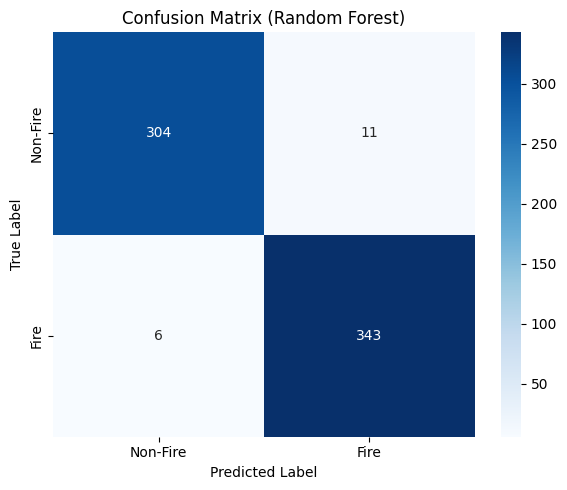

In [19]:
# --- Random Forest (Without Transfer Learning) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)

print("\n--- Random Forest (Without Transfer Learning) ---")
print(classification_report(y_test, y_pred_rf, target_names=["Non-Fire", "Fire"]))
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fire", "Fire"],
            yticklabels=["Non-Fire", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8156 - loss: 1.5921
Epoch 1: val_accuracy improved from -inf to 0.95783, saving model to fire_detection_model_transfer_learning.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8164 - loss: 1.5809 - val_accuracy: 0.9578 - val_loss: 0.1219
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9558 - loss: 0.1322
Epoch 2: val_accuracy improved from 0.95783 to 0.97892, saving model to fire_detection_model_transfer_learning.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9558 - loss: 0.1321 - val_accuracy: 0.9789 - val_loss: 0.0652
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9743 - loss: 0.0693
Epoch 3: val_accuracy did not improve from 0.97892
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9744 - loss: 0.0692 - val_accuracy: 0.9759 - val_loss: 0.0597
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9875 - loss: 0.0457
Epoch 4: val_accuracy did not improve from 0.97892
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9876 - loss: 0.0456 - val_accuracy: 0.9759 - val_loss: 0.0937
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9915 - loss: 0.0437
Epoch 5: val_accuracy improved from 0.97892 to 0.98494, saving model to fire_detection_model_transfer_learning.h5


73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9915 - loss: 0.0434 - val_accuracy: 0.9849 - val_loss: 0.1029
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9947 - loss: 0.0155
Epoch 6: val_accuracy did not improve from 0.98494
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9946 - loss: 0.0157 - val_accuracy: 0.9819 - val_loss: 0.0954
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822 - loss: 0.0671
Epoch 7: val_accuracy did not improve from 0.98494
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9821 - loss: 0.0674 - val_accuracy: 0.9488 - val_loss: 0.3745
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9813 - loss: 0.0679
Epoch 8: val_accuracy did not improve from 0.98494
73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9813 - loss: 0.0677 - val_accuracy: 0.9849 - val_loss: 0.0528
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9988 - loss: 0.0072
Epoch 9: val_accuracy did not improve from 0.98494
73/7

73/73 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9968 - loss: 0.0156 - val_accuracy: 0.9880 - val_loss: 0.0547
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9990 - loss: 0.0014
Epoch 12: val_accuracy did not improve from 0.98795
73/73 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9990 - loss: 0.0014 - val_accuracy: 0.9880 - val_loss: 0.0862
Epoch 13/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9998 - loss: 5.8191e-04
Epoch 13: val_accuracy did not improve from 0.98795
73/73 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9998 - loss: 6.3241e-04 - val_accuracy: 0.9880 - val_loss: 0.0615
Epoch 14/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9947 - loss: 0.0211
Epoch 14: val_accuracy did not improve from 0.98795
73/73 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9946 - loss: 0.0215 - val_accuracy: 0.9639 - val_loss: 0.0877
Epoch 15/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.0230
Epoch 15: val_accuracy did not improve f

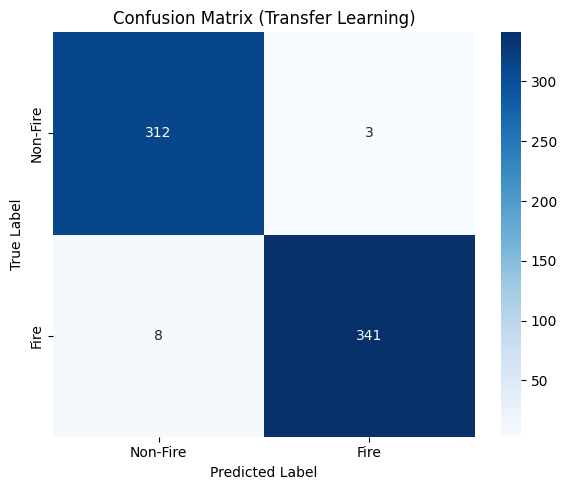

In [20]:
# --- Transfer Learning Model (VGG16) ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:15]:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_path = "fire_detection_model_transfer_learning.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    X_train_augmented, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

y_pred_proba_tl = model.predict(X_test)
y_pred_tl = (y_pred_proba_tl > 0.5).astype(int)

print("\n--- Transfer Learning Model (VGG16) ---")
print(classification_report(y_test, y_pred_tl, target_names=["Non-Fire", "Fire"]))
cm_tl = confusion_matrix(y_test, y_pred_tl)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fire", "Fire"],
            yticklabels=["Non-Fire", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Transfer Learning)")
plt.tight_layout()
plt.show()


--- KNN (Without Transfer Learning) ---

              precision    recall  f1-score   support

    Non-Fire       0.69      1.00      0.81       315
        Fire       1.00      0.59      0.74       349

    accuracy                           0.78       664
   macro avg       0.84      0.79      0.78       664
weighted avg       0.85      0.78      0.77       664



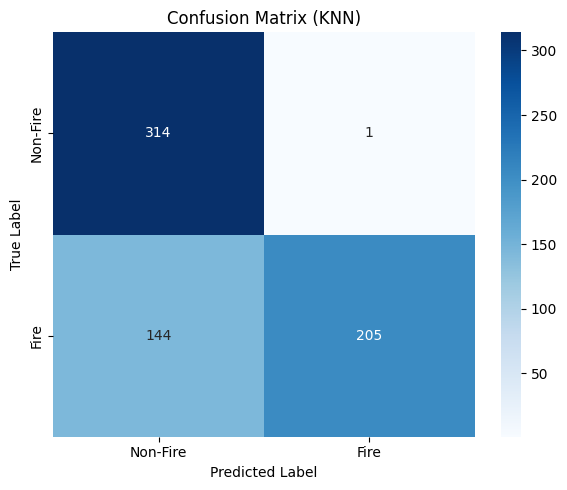

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# Train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred_knn = knn_classifier.predict(X_test_features)

# Generate the classification report and confusion matrix
print("\n--- KNN (Without Transfer Learning) ---\n")
print(classification_report(y_test, y_pred_knn, target_names=["Non-Fire", "Fire"]))

cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fire", "Fire"],
            yticklabels=["Non-Fire", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (KNN)")
plt.tight_layout()
plt.show()

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.6619 - loss: 0.5898 - val_accuracy: 0.9337 - val_loss: 0.2724
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.9123 - loss: 0.2698 - val_accuracy: 0.9488 - val_loss: 0.1739
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.9421 - loss: 0.1806 - val_accuracy: 0.9518 - val_loss: 0.1383
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - accuracy: 0.9474 - loss: 0.1526 - val_accuracy: 0.9518 - val_loss: 0.1248
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.9671 - loss: 0.1167 - val_accuracy: 0.9548 - val_loss: 0.1208
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.9669 - loss: 0.1111 - val_accuracy: 0.9578 - val_loss: 0.1121
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9703 - loss: 0.0997 - val_accuracy: 0.9548 - val_loss: 0.1146
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step - accuracy: 0.9782 - loss: 0.0839 - val_accu

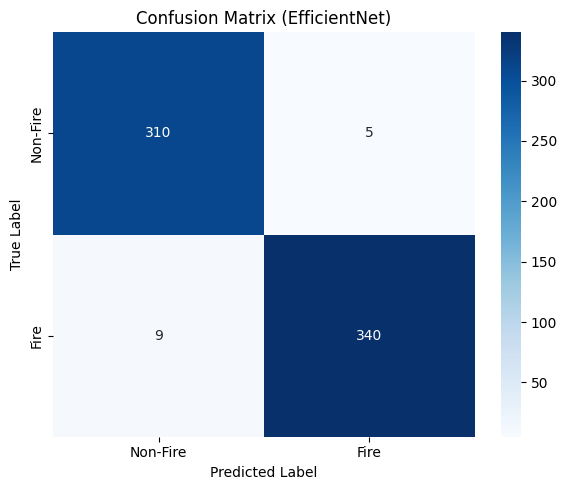

In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top
model_efficientnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_efficientnet.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val), 
                                  epochs=50,
                                  batch_size=32,
                                  callbacks=[early_stopping])


# Make predictions
y_pred_efficientnet_probs = model_efficientnet.predict(X_test)
y_pred_efficientnet = (y_pred_efficientnet_probs > 0.5).astype(int)

# Generate the classification report and confusion matrix
print("\n--- EfficientNet (Transfer Learning) ---\n")
print(classification_report(y_test, y_pred_efficientnet, target_names=["Non-Fire", "Fire"]))

cm_efficientnet = confusion_matrix(y_test, y_pred_efficientnet)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fire", "Fire"],
            yticklabels=["Non-Fire", "Fire"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EfficientNet)")
plt.tight_layout()
plt.show()

In [23]:
results_path = "fire_detection_results.txt"
with open(results_path, "w") as f:
    f.write("--- Random Forest (Without Transfer Learning) ---\n")
    f.write(classification_report(y_test, y_pred_rf, target_names=["Non-Fire", "Fire"]))
    f.write("\n--- Transfer Learning Model (VGG16) ---\n")
    f.write(classification_report(y_test, y_pred_tl, target_names=["Non-Fire", "Fire"]))
    f.write("\n--- KNN (Without Transfer Learning) ---\n")
    f.write(classification_report(y_test, y_pred_knn, target_names=["Non-Fire", "Fire"]))
    f.write("\n--- EfficientNet (Transfer Learning) ---\n")
    try:
        f.write(classification_report(y_test, y_pred_efficientnet, target_names=["Non-Fire", "Fire"]))
    except NameError:
        f.write("EfficientNet results not available due to error during processing.\n")